# Table of Contents
- [Data gathering and preparation](#prep-start)
    - [FRED data](#prep-fred)
    - [FDIC data](#prep-fdic)
- [Initial data exploration](#explo-start)
    - [FRED time series plots](#explo-fred)
    - [FDIC distributions and outlier detection](#explo-fdic)
    - [Merging FRED and FDIC data](#explo-merge)
    - [Summary statistics](#explo-summary)
    - [Correlation heatmap](#explo-corr)
- [Modelling and analysis](#supervised)
    - [Results and interpretation](#supervised-results)

In [1]:
from fredapi import Fred
import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyarrow.feather import read_feather, write_feather

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 50)

In banking, forecasting deposit movements helps to manage cash flows and inform lending and investing decisions. Our goal is specifically to forecast bank deposit size using key macroeconomic indicators and bank-level data.

[Github repository](https://github.com/hughdingb58/deposit_size_prediction)

<a id="prep-start"></a>
# Data gathering and preparation

<a id="prep-fred"></a>
## FRED data

In [3]:
# Read in FRED API key
f = open("fred_api_key.txt", "r")
api_key = f.read().strip()
fred_con = Fred(api_key = api_key)

In [4]:
fred_series = {
    "GDPC1": "gdp",
    "CPIAUCNS": "cpi",
    "UNRATE": "unemployment_rate",
    "FEDFUNDS": "fed_fund_rate",
    "GS10": "treasury_10yr_constant_maturity_rate",
    "GPDIC1": "private_domestic_investment",
    "GPDIC96": "private_domestic_investment_excl_iva_ccadj",
    "FGEXPND": "fed_govt_expenditures",
    "SLEXPND": "state_local_govt_expenditures",
    "NETEXP": "net_exports_good_services",
    "HOUST": "housing_starts",
    "HSN1F": "new_one_family_houses_sold",
    "CSUSHPINSA": "case_shiller_us_national_home_price_index",
    "RETAILMPCSMSA": "advance_real_retail_food_services_sales",
    "INDPRO": "industrial_production_index",
    "DSPIC96": "disposable_personal_income",
    "RRSFS": "retail_food_services_sales",
    "PSAVERT": "personal_savings_rate",
    "UMCSENT": "umich_consumer_sentiment_index",
    "TDSP": "household_debt_service_payments_pct_disposable_income",
    "DRCCLACBS": "credit_card_delinquency_rate",
    "TOTALSL": "consumer_credit_owned_securitized_outstanding",
    "CPILFESL": "cpi_urban_consumers_less_food_energy",
    "AHETPI": "avg_hrly_earnings_production_nonsupervisory_employees",
    "MEHOINUSA672N": "real_median_household_income",
    "PCEC96": "pce",
    "TOTALSA": "total_vehicle_sales"
}

econ_full = pd.DataFrame()

# Loop through each series code and pull data
for code in fred_series.keys():
    print(code)
    series = fred_con.get_series(code,
                                 observation_start = "2000-01-01",
                                 observation_end = "2023-12-31")
    econ_full[code] = series

GDPC1
CPIAUCNS
UNRATE
FEDFUNDS
GS10
GPDIC1
GPDIC96
FGEXPND
SLEXPND
NETEXP
HOUST
HSN1F
CSUSHPINSA
RETAILMPCSMSA
INDPRO
DSPIC96
RRSFS
PSAVERT
UMCSENT
TDSP
DRCCLACBS
TOTALSL
CPILFESL
AHETPI
MEHOINUSA672N
PCEC96
TOTALSA


In [5]:
# Rename columns to be more descriptive
econ = econ_full.rename(columns = fred_series)

# Keep date as column
econ = econ.reset_index().rename(columns = {"index": "date"})
# Add year and quarter columns for merging
econ["year"] = econ["date"].dt.year
econ["quarter"] = econ["date"].dt.quarter

# Cache values
write_feather(econ, "fred_econ.feather")

In [6]:
econ = read_feather("fred_econ.feather")
econ.head()

,date,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,year,quarter
0,2000-01-01,13878.147,168.8,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.000,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581284,4.43,1538.52018,179.3,13.75,67470.0,NaN,18.635,2000,1
1,2000-04-01,14130.908,171.3,3.8,6.02,5.99,2490.501,2424.549,1908.645,1331.564,-362.501,1626.0,841.0,102.540,-1.6,92.6838,9913.7,158599.0,4.3,109.2,11.726934,4.51,1570.52774,180.3,13.89,NaN,NaN,17.939,2000,2
2,2000-07-01,14145.312,172.8,4.0,6.54,6.05,2466.375,2394.141,1918.617,1357.309,-393.867,1463.0,887.0,105.721,-0.4,92.8458,10035.9,157863.0,4.7,108.3,11.882996,4.53,1629.75144,181.5,14.02,NaN,NaN,17.316,2000,3
3,2000-10-01,14229.765,174.0,3.9,6.51,5.74,2471.534,2395.566,1938.796,1382.641,-411.343,1549.0,933.0,107.728,-0.2,92.6418,10139.2,159245.0,4.3,105.8,12.071449,4.57,1684.59932,182.6,14.17,NaN,NaN,17.514,2000,4
4,2001-01-01,14183.120,175.1,4.2,5.98,5.16,2358.969,2285.261,1982.626,1431.089,-402.653,1600.0,936.0,109.214,0.8,91.8903,10211.7,158789.0,4.5,94.7,12.174616,4.81,1729.85168,183.9,14.29,66360.0,NaN,17.652,2001,1


<a id="prep-fdic"></a>
## FDIC data

FDIC data is gathered from its [API](https://banks.data.fdic.gov/docs/).

In [7]:
fdic_url = "https://banks.data.fdic.gov/api/"

### Bank metadata

In [8]:
institutions_url = fdic_url + "institutions"

institutions_params = {
    "filters": "ACTIVE:1",
    "sort_by": "OFFICES",
    "sort_order": "DESC",
    "limit": 10000,
    "format": "json"
}

# Get list of institutions from API
res = requests.get(institutions_url, params = institutions_params)
institutions_data = res.json()["data"]

In [9]:
# Read data into list
institutions_list = []
for row in institutions_data:
    curr_bank = pd.DataFrame(row["data"], index = [0])
    institutions_list.append(curr_bank)

# Bind list into table
institutions_full = pd.concat(institutions_list, axis = 0).reset_index(drop = True)

In [10]:
# Keep only relevant columns
institutions = institutions_full[["NAMEHCR", "ZIP"]].drop_duplicates()
institutions = institutions[institutions["NAMEHCR"] != ""].reset_index(drop = True)
institutions["ZIP"] = institutions["ZIP"].astype(str)
institutions.head()

,NAMEHCR,ZIP
0,JPMORGAN CHASE&CO,43240
1,WELLS FARGO&COMPANY,57104
2,BANK OF AMERICA CORP,28202
3,PNC FINL SERVICES GROUP INC,19801
4,U S BCORP,45202


In [11]:
print("Number of active institutions: " + str(institutions.shape[0]))

Number of active institutions: 3815


### Financial data

In [12]:
fdic_series = {
    "NAMEHCR": "name",
    "ZIP": "zip",
    "REPDTE": "date",
    "CLCODE": "classcode",
    "ASSET": "total_assets",
    "NETINCQ": "net_income_quarterly",
    "OFFOA": "offices_us",
    "OFFFOR": "offices_foreign",
    "ROAQ": "roa_quarterly",
    "ROEQ": "roe_quarterly",
    "EINTXQA": "total_interest_expense_quarterly",
    "NONIXQA": "non_interest_expense_quarterly",
    "DEP": "total_deposits",
    "SC1LES": "debt_securities_maturity_1yr_or_less"
}

fields_str = ",".join(fdic_series.keys())
fields_sum_str = ",".join(list(fdic_series.keys())[4:])
print(fields_str)
print(fields_sum_str)

NAMEHCR,ZIP,REPDTE,CLCODE,ASSET,NETINCQ,OFFOA,OFFFOR,ROAQ,ROEQ,EINTXQA,NONIXQA,DEP,SC1LES
ASSET,NETINCQ,OFFOA,OFFFOR,ROAQ,ROEQ,EINTXQA,NONIXQA,DEP,SC1LES


In [13]:
financials_url = fdic_url + "financials"

financials_list = []

# Loop through banks
for i in range(institutions.shape[0]):
    institution_row = institutions.iloc[i]
    financials_params = {
        "filters": 'NAMEHCR:"' + str(institution_row["NAMEHCR"]) + '",ZIP:"' + str(institution_row["ZIP"]) + '"',
        "fields": fields_str,
        "sort_by": "REPDTE",
        "sort_order": "DESC",
        "limit": 10000,
        "agg_term_fields": "NAMEHCR,ZIP,REPDTE",
        "agg_sum_fields": fields_sum_str,
        "format": "json"
    }

    # Get list of institutions from API
    res = requests.get(financials_url, params = financials_params)
    financials_data = res.json()["data"]
    
    # Read data into list
    for row in financials_data:
        curr_bank = pd.DataFrame(row["data"], index = [0])
        financials_list.append(curr_bank)

    # To keep track of progress
    if (i % 200) == 0:
        print("row " + str(i) + ": " + str(institution_row["NAMEHCR"]))

row 0: JPMORGAN CHASE&CO
row 200: FIRST OF LONG ISLAND CORP THE
row 400: ADAGE LLC
row 600: SOUTHEAST BANCSHARES INC
row 800: GREAT SOUTHERN CAPITAL CORP
row 1000: CLINTON FINANCIAL SERVICES MHC
row 1200: MIDWEST BCORP &AFFILIATES ESOP TR
row 1400: TRISTAR BANCSHARES INC
row 1600: CORNERSTONE FINANCIAL CORP
row 1800: HOCKING VALLEY BANCSHARES INC
row 2000: DUNDEE BANCO INC
row 2200: FIRST MUTUAL HOLDING CO
row 2400: F&M FINANCIAL SERVICES INC
row 2600: CINCINNATUS CMTY BCORP MHC
row 2800: FIRST LEROY BCORP INC
row 3000: CHISHOLM TRAIL FINANCIAL CORP
row 3200: LAKEVIEW BCORP INC
row 3400: ADINO CO THE
row 3600: RAYMOND JAMES FINANCIAL INC
row 3800: PINERIES BANKSHARES INC


In [14]:
# Bind list into table
financials_full = pd.concat(financials_list, axis = 0).reset_index(drop = True)

In [15]:
# Set more descriptive column names
financials = financials_full.rename(columns = fdic_series)
# Clean column data types
financials["date"] = pd.to_datetime(financials["date"], format = "%Y%m%d")
financials["zip"] = financials["zip"].astype(str)
# Filter to holding companies only
financials = financials[financials["classcode"] <= 65]
# Filter to data after 2000 only, to match FRED data time frame
financials = financials[financials["date"] >= "2000-01-01"]
# Add year and quarter columns for merging
financials["year"] = financials["date"].dt.year
financials["quarter"] = financials["date"].dt.quarter
# Sort data
financials = financials.sort_values(["name", "zip", "date"])
# Manual inspection
financials.sample(n = 10, random_state = 0)

,zip,name,date,total_assets,roa_quarterly,total_interest_expense_quarterly,total_deposits,non_interest_expense_quarterly,roe_quarterly,offices_foreign,debt_securities_maturity_1yr_or_less,classcode,net_income_quarterly,offices_us,ID,year,quarter
680580,2903,BANK OF AMERICA CORP,2004-12-31,218740377,1.58,1939392,145630599,5571784,7.22,103,1724960,3,847484,0,2558_20041231,2004,4
695090,79546,ROTAN BANCSHARES INC,2005-03-31,41410,1.00,612,36986,1948,9.33,0,2033,3,101,0,34455_20050331,2005,1
362482,67013,MORLEY BANCSHARES CORP,2008-09-30,111357,0.94,2844,99772,2508,9.81,0,5679,21,264,0,15038_20080930,2008,3
266278,76450,FIRST GRAHAM BCORP INC,2012-09-30,256750,1.93,1156,225015,6292,17.26,0,195,3,1237,0,3226_20120930,2012,3
205233,15301,WFSB MUTUAL HOLDING CO,2014-12-31,1088530,0.75,2644,962880,22416,7.17,0,922,41,2000,0,29520_20141231,2014,4
654040,66436,FARMERS STATE BANKSHARES INC,2019-12-31,58306,2.09,404,49398,1576,15.64,0,0,21,301,0,15258_20191231,2019,4
332978,44820,COMMUNITY INVESTORS BCORP INC,2021-12-31,233973,0.77,1220,187827,10776,9.39,0,337,33,447,0,29705_20211231,2021,4
11178,48104,COMERICA INC,2023-09-30,95367,27.42,0,632,65796,28.34,0,0,3,6327,0,1596_20230930,2023,3
478711,68633,FARMERS STATE BANCSHARES INC,2013-12-31,91630,1.79,608,71354,2680,15.96,0,583,21,397,0,16116_20131231,2013,4
701253,73098,GARVIN COUNTY BANCSHARES INC,2006-06-30,49208,2.07,1180,39897,1456,22,0,1667,21,247,0,4232_20060630,2006,2


Most data values look reasonable, but we exclude some columns:

- The ID doesn't seem to be immediately meaningful.
- The office counts don't seem to be properly filled in.
- RoA and RoE are ratios, so they will be difficult to aggregate.
- We no longer need classcode.

We also see that some banks have multiple locations, so we aggregate them.

In [16]:
# Remove unneeded columns
financials = financials.drop(["ID", "offices_foreign", "offices_us",
                              "roe_quarterly", "roa_quarterly",
                              "zip", "classcode"], axis = 1)
# Aggregate by bank name
financials = financials.groupby(["name", "date", "year", "quarter"]).agg("sum").reset_index()
# Cache values
write_feather(financials, "fdic_financials.feather")

In [17]:
financials = read_feather("fdic_financials.feather")

<a id="explo-start"></a>
# Initial data exploration

We first visualize the FDIC and FRED data separately, and then join them together to check for summary statistics and correlations.

<a id="explo-fred"></a>
## FRED time series plots

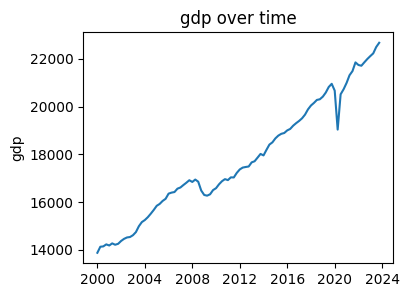

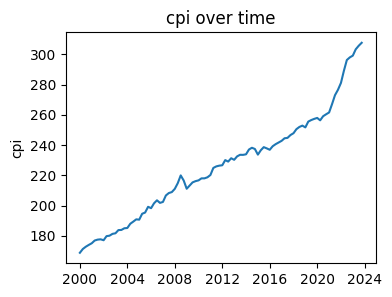

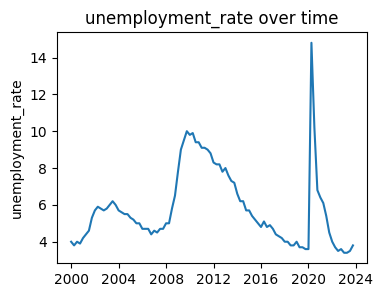

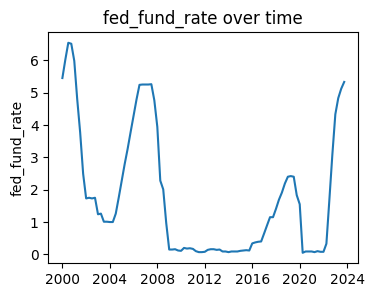

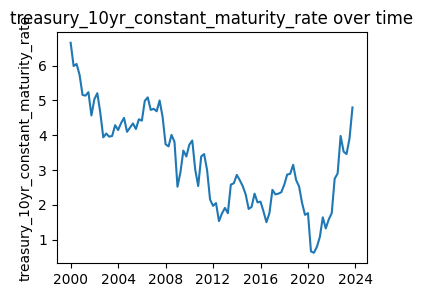

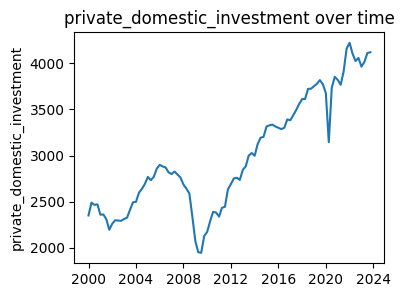

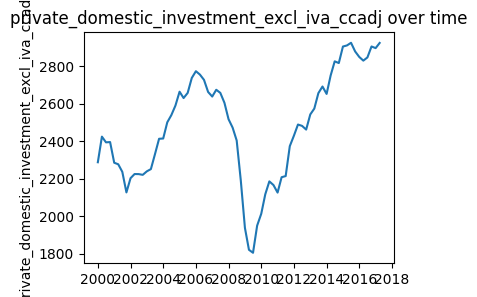

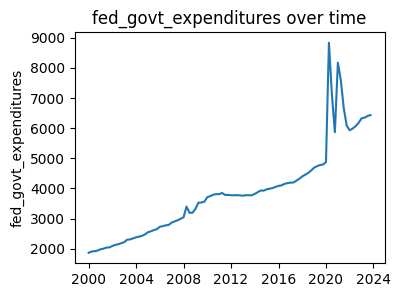

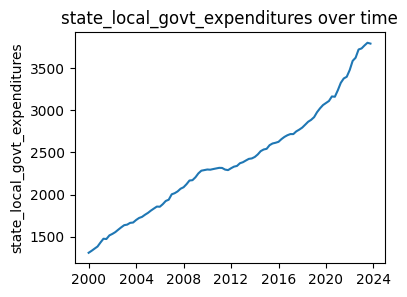

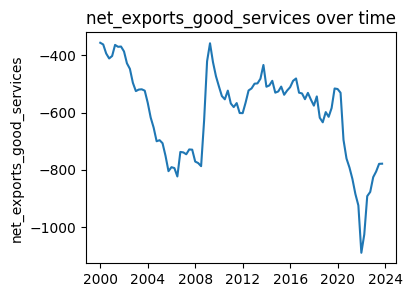

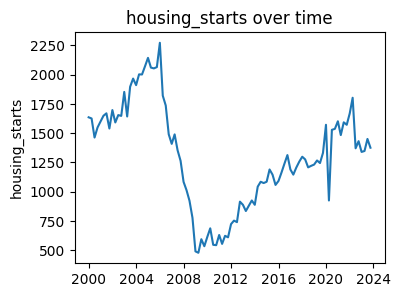

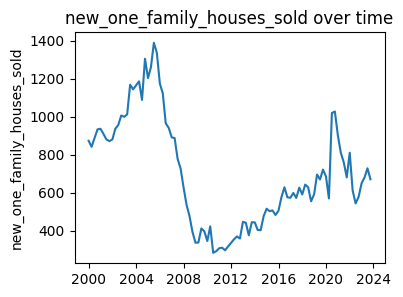

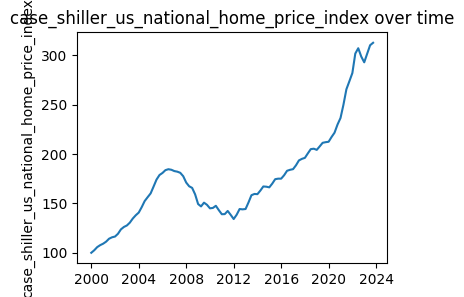

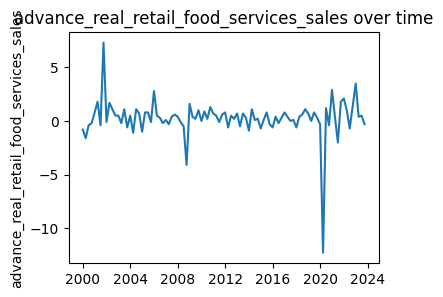

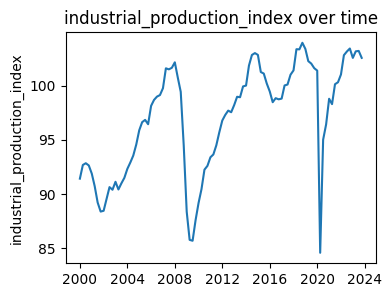

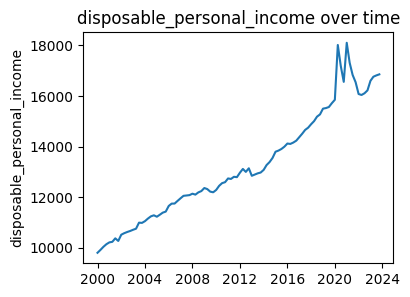

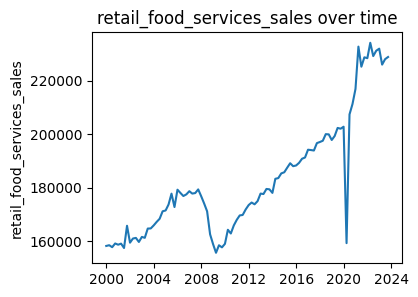

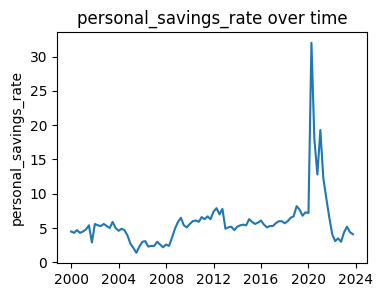

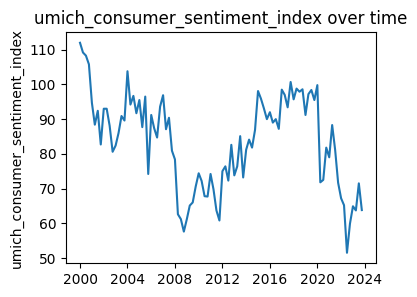

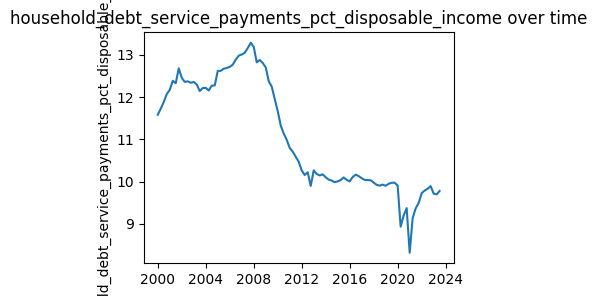

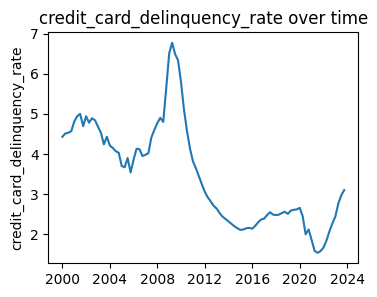

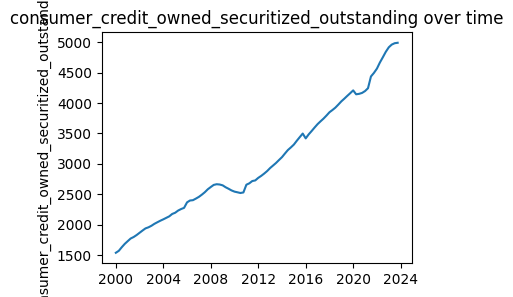

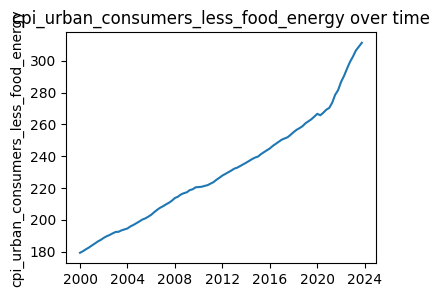

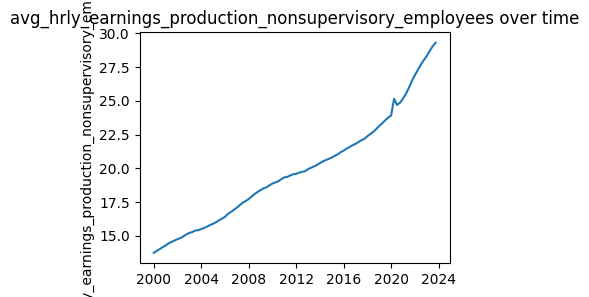

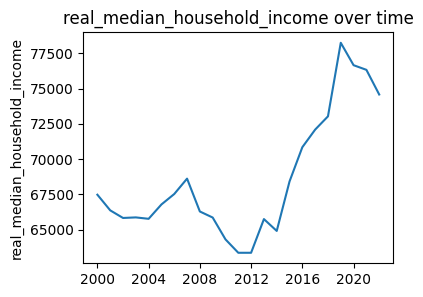

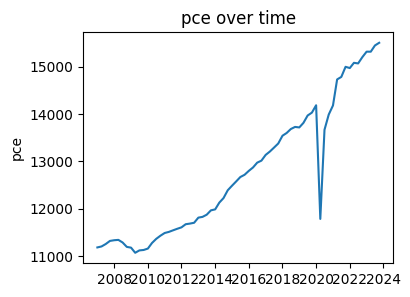

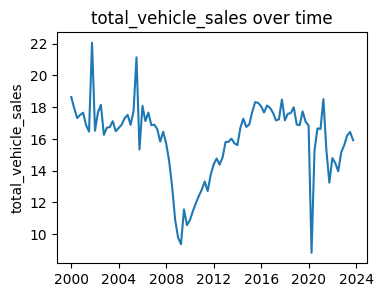

In [18]:
for indicator in econ.columns[1:-2]:
    plt.figure(figsize = (4, 3))
    ax = sns.lineplot(econ, x = "date", y = indicator)
    ax.set_title(indicator + " over time")
    ax.set_xlabel("")
    plt.show()

All FRED indicators appear to follow reasonable and expected trends over time (naturally with fluctuations during the 2020 pandemic), and there do not appear to be significant outliers.

<a id="explo-fdic"></a>
## FDIC distributions and outlier detection

We first plot a histogram of a proxy of our outcome variable, deposit size.

<Axes: xlabel='total_deposits', ylabel='Count'>

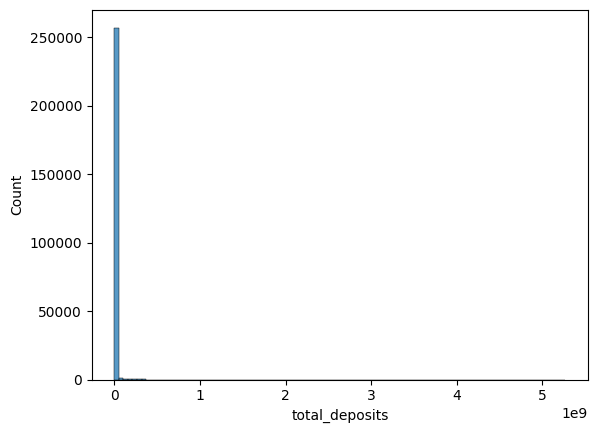

In [19]:
sns.histplot(financials, x = "total_deposits", bins = 100)

We see that the vast majority of banks have deposit sizes that are far smaller than the largest banks. However, since our analysis is from a macroeconomic perspective, we are interested in categories of banks rather than individual banks. We aggregate the banks into three equally weighted categories for large, intermediate, and small banks (based on [OCC categorizations](https://www.occ.gov/news-issuances/bulletins/2021/bulletin-2021-5.html)).

In [20]:
financials["total_assets_last"] = financials.groupby(
    ["name"]
)["total_assets"].transform("last")
financials["category"] = np.select(
    [financials["total_assets_last"] >= 2500000000,
     financials["total_assets_last"] >= 600000000],
    ["large", "intermediate"], default = "small"
)

financials.groupby(["category"]).agg({"total_assets_last": "sum"})

,total_assets_last
category,
intermediate,532444389472
large,1525336569588
small,1119214096756


These thresholds seem reasonable (the three aggregate categories are comparably sized), so we will use them for now.

In [21]:
financials_agg = financials.drop(["name"], axis = 1). \
  groupby(["category", "date", "year", "quarter"]).agg("sum").reset_index()
financials_agg.head()

,category,date,year,quarter,total_assets,total_interest_expense_quarterly,total_deposits,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly,total_assets_last
0,intermediate,2000-03-31,2000,1,558319105,20550976,367147508,24161608,14341318,2571182,3838925497
1,intermediate,2000-06-30,2000,2,597203394,23254692,388896435,24171144,15556297,2146797,3838925497
2,intermediate,2000-09-30,2000,3,619144497,26694724,394527160,25132440,16135172,2189389,3838925497
3,intermediate,2000-12-31,2000,4,641096047,28115956,410358973,25822732,16514098,2181289,3838925497
4,intermediate,2001-03-31,2001,1,730053169,29287200,479205515,29143224,15717210,2319569,3838925497


Now that we have reduced our data to aggregate categories we are confident we are interested in, we generate histograms for each metric, each across a period of 6 years, to visually inspect for unusual distributions.

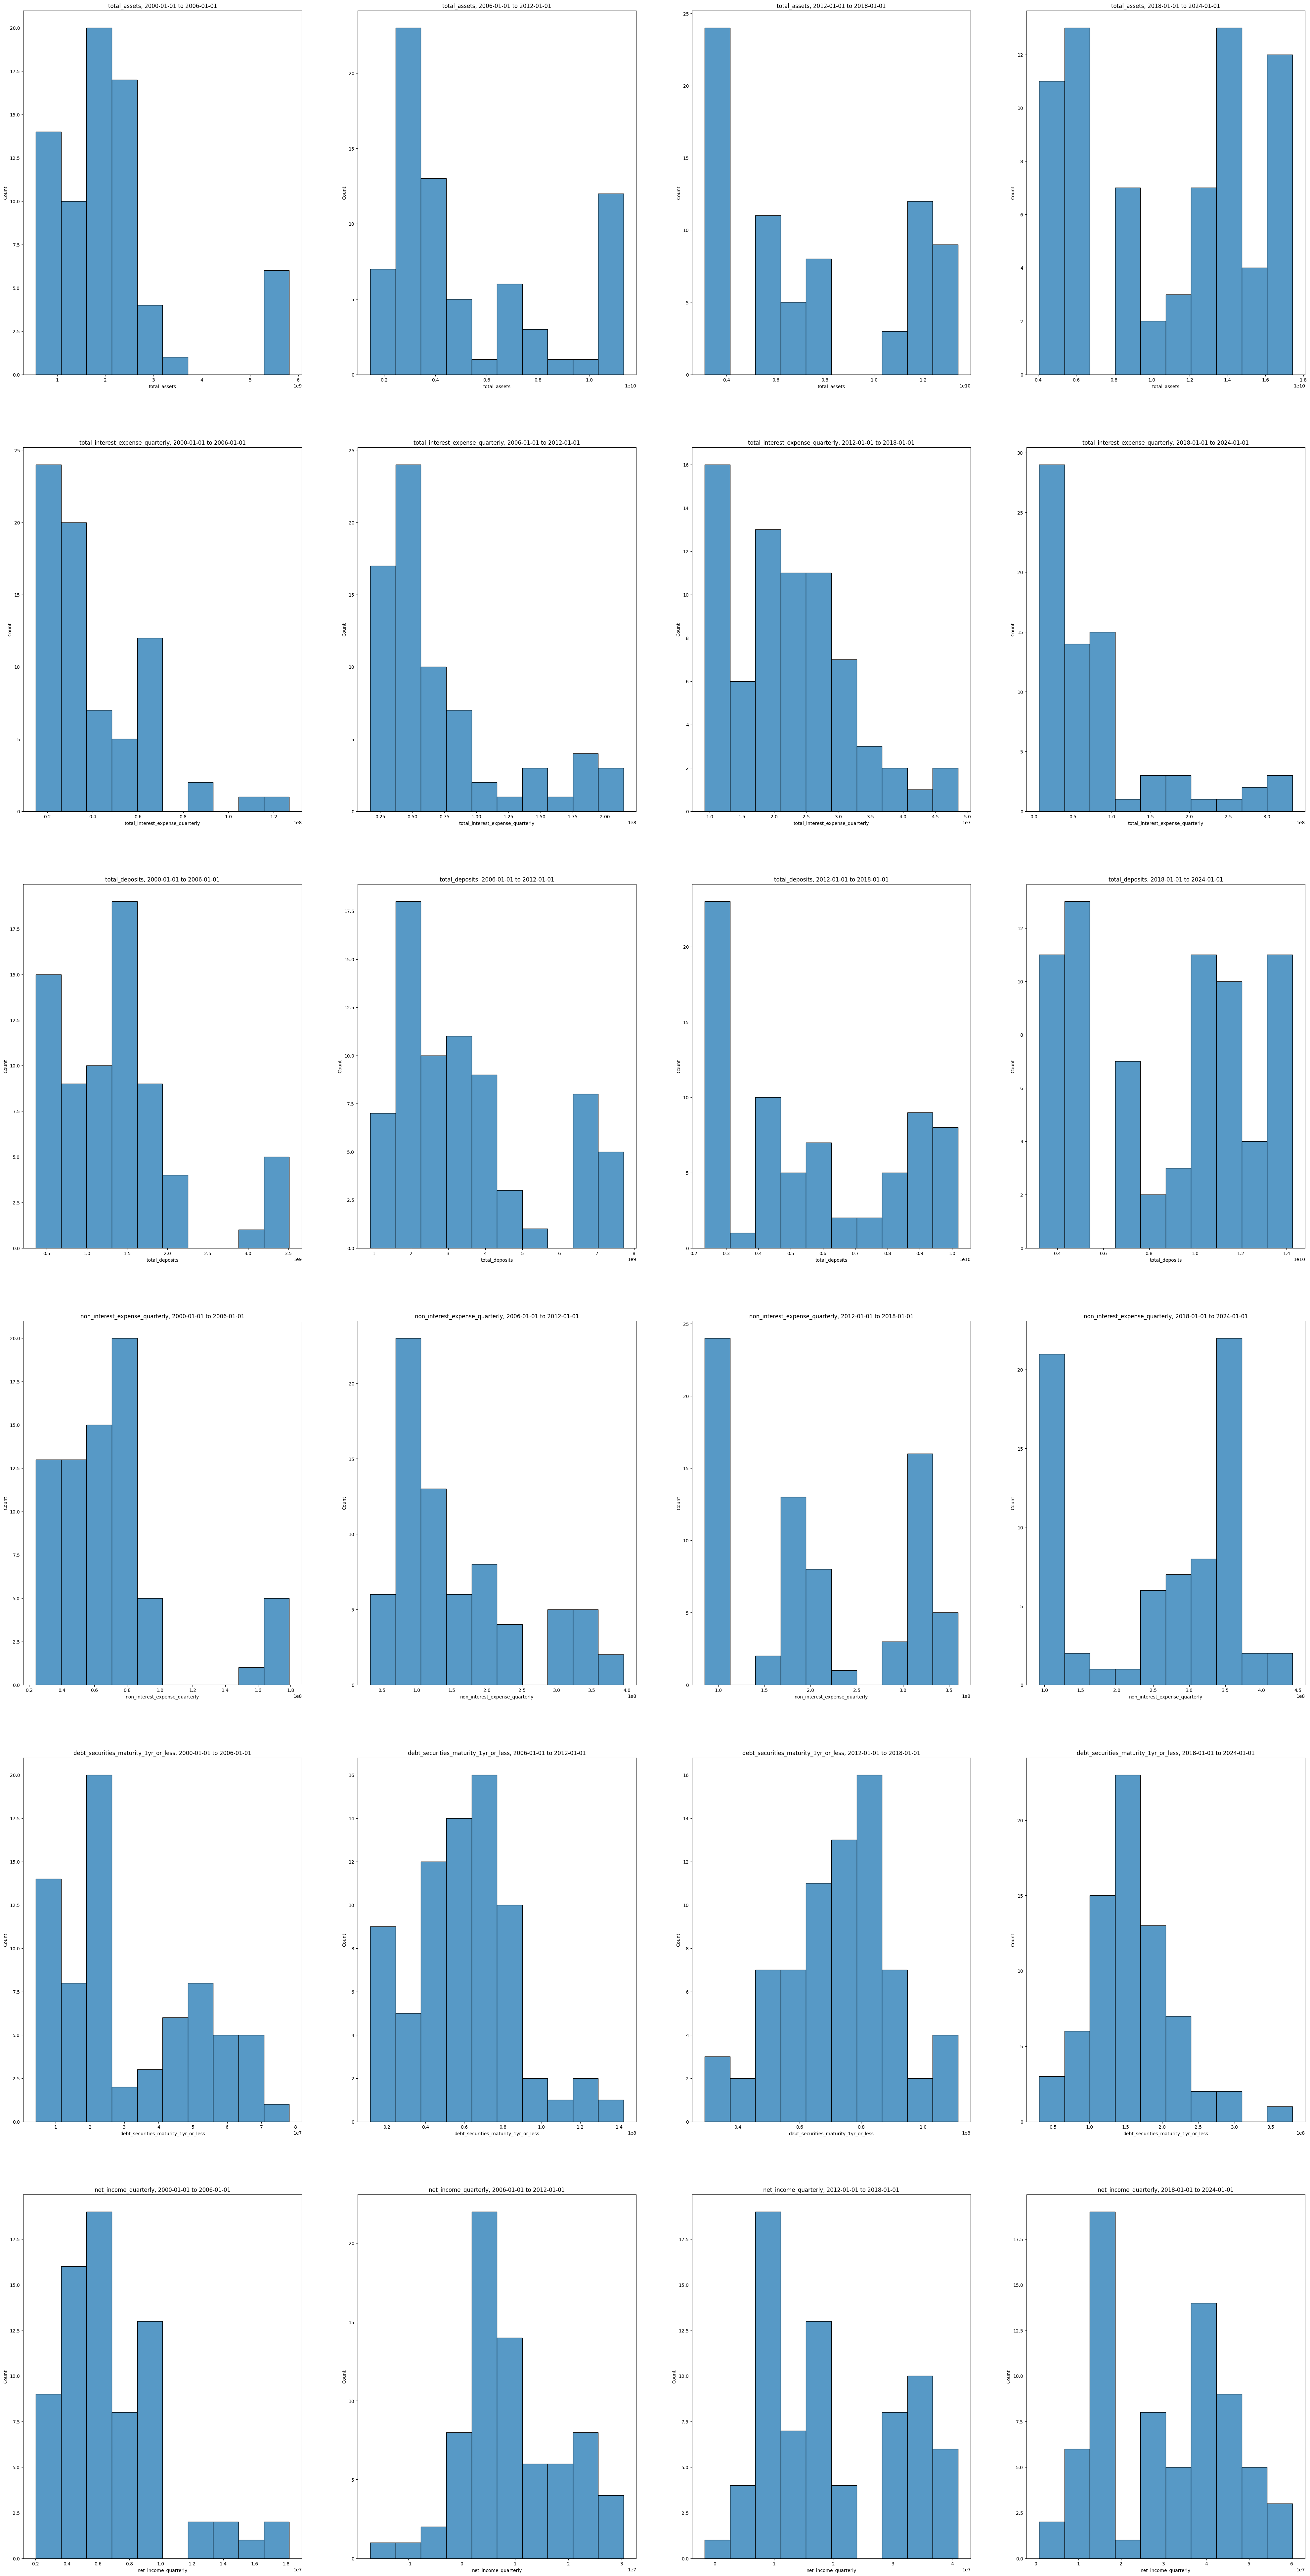

In [22]:
date_ranges = ["2000-01-01", "2006-01-01", "2012-01-01", "2018-01-01", "2024-01-01"]

desc_col_num = 4
fig, axes = plt.subplots(financials_agg.shape[1] - desc_col_num - 1,
                         len(date_ranges) - 1, figsize = (50, 100))

for i in range(1, len(date_ranges)):
    curr_data = financials_agg[(financials_agg["date"] >= date_ranges[i - 1]) &
                               (financials_agg["date"] < date_ranges[i])]
    for j in range(desc_col_num, financials_agg.shape[1] - 1):
        metric = financials_agg.columns[j]
        sns.histplot(curr_data, x = metric, bins = 10, ax = axes[j - desc_col_num, i - 1])
        axes[j - desc_col_num, i - 1].set_title(
            metric + ", " + date_ranges[i - 1] + " to " + date_ranges[i]
        )

The values seem to generally follow a very roughly normal distribution (with some skew at times), and the outliers do not seem too substantial. This matches what we would expect from the variables.

<a id="explo-merge"></a>
## Merging FRED and FDIC data

In [23]:
# Merge on quarter
df_full = pd.merge(econ.drop("date", axis = 1), financials_agg)
# Rearrange columns
cols = list(df_full.columns)
for col in ["quarter", "year", "date", "category"]:
    cols.insert(0, cols.pop(cols.index(col)))
df_full = df_full[cols].sort_values(["date", "category"])
df_full.head()

,category,date,year,quarter,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,total_deposits,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly,total_assets_last
0,intermediate,2000-03-31,2000,1,13878.147,168.8,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.00,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581284,4.43,1538.52018,179.3,13.75,67470.0,NaN,18.635,558319105,20550976,367147508,24161608,14341318,2571182,3838925497
1,large,2000-03-31,2000,1,13878.147,168.8,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.00,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581284,4.43,1538.52018,179.3,13.75,67470.0,NaN,18.635,1883198726,54144604,1179761130,63949520,22533974,5128177,10371736557
2,small,2000-03-31,2000,1,13878.147,168.8,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.00,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581284,4.43,1538.52018,179.3,13.75,67470.0,NaN,18.635,1676781590,59279320,1192104148,54480856,52131629,5119529,8858689769
3,intermediate,2000-06-30,2000,2,14130.908,171.3,3.8,6.02,5.99,2490.501,2424.549,1908.645,1331.564,-362.501,1626.0,841.0,102.54,-1.6,92.6838,9913.7,158599.0,4.3,109.2,11.726934,4.51,1570.52774,180.3,13.89,NaN,NaN,17.939,597203394,23254692,388896435,24171144,15556297,2146797,3838925497
4,large,2000-06-30,2000,2,14130.908,171.3,3.8,6.02,5.99,2490.501,2424.549,1908.645,1331.564,-362.501,1626.0,841.0,102.54,-1.6,92.6838,9913.7,158599.0,4.3,109.2,11.726934,4.51,1570.52774,180.3,13.89,NaN,NaN,17.939,1955485664,61581952,1213182709,61416868,23928833,6067652,10371736557


Next, we scale and center the metrics so that they are all treated equally when modelling.

In [24]:
df = df_full.copy()
for i in df.columns[4:]:
    df[i] = df[i] - np.mean(df[i])  # Center values
    df[i] = df[i] / np.max([np.nanmax(df[i]), np.nanmin(df[i]) * -1])  # Scale values
df.head()

,category,date,year,quarter,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,total_deposits,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly,total_assets_last
0,intermediate,2000-03-31,2000,1,-0.803578,-0.699897,-0.200695,0.770717,1.000000,-0.524265,-0.283352,-0.400540,-0.770237,0.499975,0.343532,0.252851,-0.564794,-0.084881,-0.448215,-0.699090,-0.481076,-0.049410,0.885898,0.187021,0.292651,-0.768844,-0.645861,-0.651288,-0.118812,NaN,0.370717,-0.528292,-0.114305,-0.465832,-0.535784,-0.218995,-0.320396,-1.000000
1,large,2000-03-31,2000,1,-0.803578,-0.699897,-0.200695,0.770717,1.000000,-0.524265,-0.283352,-0.400540,-0.770237,0.499975,0.343532,0.252851,-0.564794,-0.084881,-0.448215,-0.699090,-0.481076,-0.049410,0.885898,0.187021,0.292651,-0.768844,-0.645861,-0.651288,-0.118812,NaN,0.370717,-0.408223,0.005616,-0.380045,-0.389725,-0.191650,-0.261764,-0.091695
2,small,2000-03-31,2000,1,-0.803578,-0.699897,-0.200695,0.770717,1.000000,-0.524265,-0.283352,-0.400540,-0.770237,0.499975,0.343532,0.252851,-0.564794,-0.084881,-0.448215,-0.699090,-0.481076,-0.049410,0.885898,0.187021,0.292651,-0.768844,-0.645861,-0.651288,-0.118812,NaN,0.370717,-0.426930,0.023945,-0.378742,-0.424483,-0.092862,-0.261962,-0.302065
3,intermediate,2000-06-30,2000,2,-0.751720,-0.669295,-0.222930,0.890617,0.802711,-0.410811,-0.080553,-0.392025,-0.753730,0.487866,0.333226,0.206516,-0.546101,-0.148541,-0.346485,-0.675815,-0.475718,-0.057042,0.798617,0.239892,0.316834,-0.752442,-0.633400,-0.636412,NaN,NaN,0.273378,-0.524768,-0.104653,-0.463536,-0.535749,-0.214939,-0.330127,-1.000000
4,large,2000-06-30,2000,2,-0.751720,-0.669295,-0.222930,0.890617,0.802711,-0.410811,-0.080553,-0.392025,-0.753730,0.487866,0.333226,0.206516,-0.546101,-0.148541,-0.346485,-0.675815,-0.475718,-0.057042,0.798617,0.239892,0.316834,-0.752442,-0.633400,-0.636412,NaN,NaN,0.273378,-0.401672,0.032165,-0.376517,-0.399022,-0.186994,-0.240222,-0.091695


<a id="explo-summary"></a>
## Summary statistics

In [25]:
df.describe()

,date,year,quarter,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,total_deposits,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly,total_assets_last
count,288,288.000000,288.00000,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.100000e+02,2.880000e+02,288.000000,2.880000e+02,288.000000,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,288.000000,2.880000e+02,2.850000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,6.900000e+01,2.040000e+02,2.880000e+02,2.880000e+02,288.000000,2.880000e+02,288.000000,288.000000,2.880000e+02,2.880000e+02
mean,2012-02-14 06:00:00,2011.500000,2.50000,2.467162e-17,-3.207311e-16,5.551115e-17,-2.467162e-17,7.401487e-17,-3.207311e-16,-4.398598e-16,-7.401487e-17,0.000000,-8.018277e-17,0.000000,-2.467162e-17,-4.934325e-17,7.709882e-19,4.934325e-16,-2.713879e-16,-1.727014e-16,0.000000,-3.639064e-16,-9.972530e-17,-2.467162e-17,-1.480297e-16,-7.401487e-17,-3.700743e-16,3.861645e-16,-2.089832e-16,2.498002e-16,-2.467162e-17,0.000000,2.467162e-17,0.000000,0.000000,1.233581e-17,-2.467162e-17
min,2000-03-31 00:00:00,2000.000000,1.00000,-8.035781e-01,-6.998973e-01,-2.674001e-01,-3.651781e-01,-7.785412e-01,-8.536451e-01,-1.000000e+00,-4.005403e-01,-0.770237,-1.000000e+00,-0.849860,-6.014480e-01,-5.647944e-01,-1.000000e+00,-1.000000e+00,-6.990904e-01,-5.309010e-01,-0.167707,-1.000000e+00,-1.000000e+00,-5.809560e-01,-7.688436e-01,-6.458606e-01,-6.512884e-01,-5.464104e-01,-6.209420e-01,-1.000000e+00,-5.282918e-01,-0.163992,-4.658315e-01,-0.535784,-0.252823,-7.725111e-01,-1.000000e+00
25%,2006-03-08 12:00:00,2005.750000,1.75000,-3.198190e-01,-3.305300e-01,-1.590041e-01,-3.467724e-01,-3.324336e-01,-4.347566e-01,-3.593495e-01,-2.311392e-01,-0.381055,-2.675296e-01,-0.321181,-3.328507e-01,-2.427617e-01,-3.713528e-02,-3.473338e-01,-3.317338e-01,-3.388857e-01,-0.054180,-3.469494e-01,-3.964364e-01,-3.126771e-01,-3.556790e-01,-3.518012e-01,-3.720889e-01,-2.962863e-01,-4.619694e-01,-1.271310e-01,-3.420165e-01,-0.112281,-3.098992e-01,-0.322264,-0.118566,-2.363624e-01,-6.825031e-01
50%,2012-02-14 12:00:00,2011.500000,2.50000,-1.025990e-01,6.925381e-03,-6.172554e-02,-1.485166e-01,-5.416846e-02,-1.292157e-01,9.975482e-03,-1.662417e-02,-0.054685,9.661321e-02,0.003446,-9.176471e-02,-7.121488e-02,1.061008e-02,1.294001e-01,-8.026228e-02,-9.964639e-02,-0.016973,8.945677e-02,-2.159248e-01,-8.671831e-02,-1.485940e-01,-4.912555e-02,-3.232091e-02,-1.904246e-01,-8.695391e-02,9.939892e-02,-1.366756e-01,-0.070206,-1.454884e-01,-0.164994,-0.040402,-1.060390e-01,-9.169467e-02
75%,2018-01-22 12:00:00,2017.250000,3.25000,3.941821e-01,2.568955e-01,8.002316e-02,1.638547e-01,3.058095e-01,4.193182e-01,3.162117e-01,9.695349e-02,0.272171,1.896611e-01,0.314676,2.962896e-01,1.368715e-01,4.244032e-02,3.480466e-01,3.201102e-01,2.324425e-01,0.013555,3.170114e-01,4.691142e-01,3.183450e-01,3.939317e-01,2.842332e-01,2.498008e-01,3.606787e-01,3.583010e-01,2.163875e-01,3.770623e-01,0.036522,2.362807e-01,0.440365,0.061101,1.941850e-01,8.524228e-01
max,2023-12-31 00:00:00,2023.000000,4.00000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.625108e-01,1.000000e+00,1.000000,4.999749e-01,

The summary statistics per metric appear to be reasonable, and not skewed by outliers.

<a id="explo-corr"></a>
## Correlation heatmap

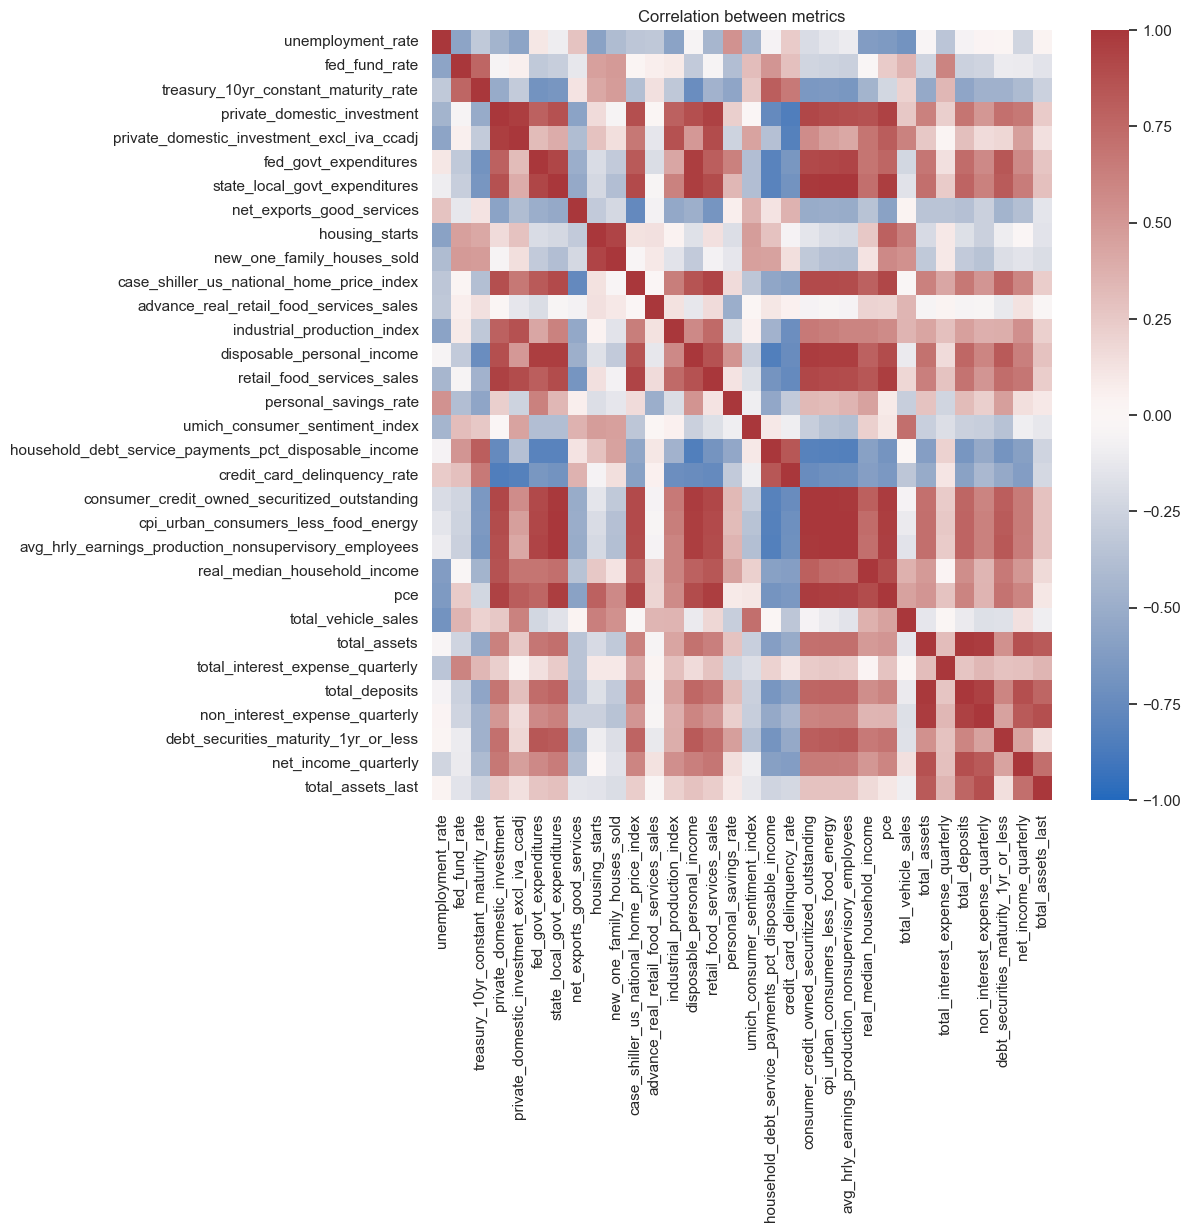

In [27]:
corr_columns = list(df.columns[6:])
sns.set(rc = {"figure.figsize": (10, 10)})
sns.heatmap(df[corr_columns].corr(), vmin = -1, vmax = 1, cmap="vlag").set_title(
    "Correlation between metrics"
)
plt.show()

As we can see, many metrics are highly correlated, which may create issues of collinearity. We will perform manual feature selection to accommodate for this.

<a id="supervised"></a>
# Modelling and analysis

<a id="supervised-results"></a>
## Results